In [1]:
# Data Prep

# import modules and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os 
from scipy import stats

my_dir = os.path.realpath('.')
db_file = os.path.join(my_dir, '../../gr_sentiment_analysis/data/books.db')
conn = sqlite3.connect(db_file)

review_stats = pd.read_sql_query('SELECT * FROM review_stats',con=conn)

# Clean up the data a bit. Remove reviews with a score of 0 since they won't be part of the prediction model 

review_stats = review_stats[review_stats['rating'] != 0]

# Review ID is not needed for this analysis so should be dropped
if review_stats.columns.contains('review_id'):
    review_stats.drop('review_id', axis=1, inplace=True)

# remove any reviews with a total AFINN or Bing count of 0, since this means there are no matching
# words in either lexicon and these reviews cannot be used in this analysis
review_stats = review_stats[(review_stats.total_afinn_count != 0) & (review_stats.total_bing_count != 0)
                           & (review_stats.total_mpqa_count != 0) & (review_stats.total_inq_count != 0)]
# this leaves 918438 total reviews

# remove outliers where the Z-score of the pos or neg word counts is < 3
review_stats = review_stats[(
    np.abs(stats.zscore(review_stats[['pos_afinn_count', 'neg_afinn_count', 
                                      'pos_bing_count', 'neg_bing_count',
                                      'pos_mpqa_count', 'neg_mpqa_count',
                                      'pos_inq_count', 'neg_inq_count']])) < 3
).all(axis=1)]

# with all outliers removed (having a count +/- 3 SDs), 889807 rows remain. 

# Rating is our target variable, the other columns are features. 
y = review_stats['rating'].values
X = review_stats.drop('rating', axis=1).values

# Create a training and testing set 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)


In [3]:
# Setup Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier()

param_forest = {'n_estimators': stats.randint(1,30), 
             'max_features': ['auto', 'log2', None],
             'criterion': ['gini', 'entropy'],
             'min_samples_split': [2, 5, 10], 
             'max_depth': [3, 5, 10, None],
             'bootstrap': [True, False]}

rf_cv = RandomizedSearchCV(rf, param_forest, cv=5, n_iter=10, n_jobs=2)



In [3]:
rf_cv.fit(X_train, y_train)



RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=2,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000017D095A8320>, 'max_features': ['auto', 'log2', None], 'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 5, 10], 'max_depth': [3, 5, 10, None], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [4]:
rf_y_pred = rf_cv.predict(X_test)

#stats 
from sklearn.metrics import classification_report
print(rf_cv.best_params_)
print(rf_cv.best_score_)

# still getting a score around 0.37, around the same as the other classifiers. Not good

{'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'min_samples_split': 5, 'n_estimators': 27}
0.376856618903


In [5]:
rf = RandomForestClassifier(max_depth=10, max_features='auto', min_samples_split=10,
                            n_estimators=18, criterion='entropy', bootstrap=True)
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)

In [6]:
rf_y_pred = rf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, rf_y_pred))


             precision    recall  f1-score   support

          1       0.37      0.01      0.02      6602
          2       0.40      0.00      0.00     15786
          3       0.29      0.03      0.05     39794
          4       0.35      0.79      0.49     61421
          5       0.47      0.32      0.38     51986

avg / total       0.38      0.38      0.30    175589



In [7]:
# let's try this
col_importance = pd.DataFrame({'col':review_stats.drop('rating', axis=1).columns,
                               'importance':rf.feature_importances_})

col_importance.sort_values('importance', ascending=False)

# from this, we see that exclamation count has an outsized influence. Is it really that important in predicting the review
# score? This is supposed to be word sentiment analysis
# bing mean, pos_bing_ratio, words_ratio, 

# unimportant columns appear to be neg_afinn_ratio, pos_afinn_ratio, neg_afinn_count, pos_afinn_count, cap_words_count, 
# total_bing_count, pos_bing_count, pos_afinn_count, bing_median

# these are the ratios of positive words 

,col,importance
45,exclamation_count,0.126355
26,pos_bing_ratio,0.086021
2,bing_mean,0.075248
39,neg_mpqa_density,0.072834
27,pos_mpqa_ratio,0.048282
1,afinn_mean,0.045379
5,afinn_median,0.043089
3,mpqa_mean,0.042814
29,neg_afinn_ratio,0.038042
6,bing_median,0.034663


In [8]:
# If I scale the values, do I get the same result? 

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# pipeline = Pipeline(steps)
scaler = StandardScaler()
minmax = MinMaxScaler()

X_train_minmax = minmax.fit_transform(X_train)
X_test_minmax = minmax.fit_transform(X_test)

rf.fit(X_train_minmax, y_train)
rf_y_pred = rf.predict(X_test_minmax)

print(classification_report(y_test, rf_y_pred))

# no, it is in fact even worse


             precision    recall  f1-score   support

          1       0.41      0.01      0.02      6602
          2       0.17      0.00      0.00     15786
          3       0.28      0.02      0.04     39794
          4       0.35      0.71      0.47     61421
          5       0.43      0.40      0.41     51986

avg / total       0.34      0.37      0.30    175589



In [9]:
X_dropped = review_stats.drop(['rating', 'bing_median', 'pos_afinn_count', 'neg_afinn_count', 'pos_bing_count', 'neg_bing_count', 
                              'exclamation_count', 'cap_words_count', 'total_afinn_count', 'total_bing_count'], axis=1).values


X_train_dropped, X_test_dropped, y_train, y_test = train_test_split(
    X_dropped, y, test_size=0.2, random_state=1)

scaler = StandardScaler()
X_train_dropped = scaler.fit_transform(X_train_dropped)
X_test_dropped = scaler.fit_transform(X_test_dropped)

rf.fit(X_train_dropped, y_train)
rf_y_pred = rf.predict(X_test_dropped)

print(classification_report(y_test, rf_y_pred))


             precision    recall  f1-score   support

          1       0.36      0.01      0.02      6602
          2       0.31      0.00      0.00     15786
          3       0.25      0.01      0.03     39794
          4       0.35      0.81      0.49     61421
          5       0.45      0.28      0.34     51986

avg / total       0.35      0.37      0.28    175589



In [10]:
rs_dropped = review_stats.drop(['rating', 'bing_median', 'pos_afinn_count', 'neg_afinn_count', 'pos_bing_count', 'neg_bing_count', 
                              'exclamation_count', 'cap_words_count', 'total_afinn_count', 'total_bing_count'], axis=1)


col_importance_dropped = pd.DataFrame({'col':rs_dropped.columns,
                               'importance':rf.feature_importances_})

col_importance_dropped.sort_values('importance', ascending=False)


,col,importance
2,bing_mean,0.095360
1,afinn_mean,0.080174
32,neg_mpqa_density,0.078173
24,neg_mpqa_ratio,0.070574
5,afinn_median,0.066019
3,mpqa_mean,0.063655
20,pos_mpqa_ratio,0.055704
19,pos_bing_ratio,0.051651
8,afinn_sum,0.046634
6,mpqa_median,0.034630


In [11]:
# Well, no luck there either. It could be that the data just doesn't work for this problem. The values are too spread out. 
# What if I just use afinn_sum, bing_sum, afinn_mean, and bing_mean

X_reduced = review_stats[['afinn_sum', 'bing_sum', 'afinn_mean', 'bing_mean']].values

X_train_reduced, X_test_reduced, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=1)

rf.fit(X_train_reduced, y_train)
rf_y_pred = rf.predict(X_test_reduced)

print(classification_report(y_test, rf_y_pred))


             precision    recall  f1-score   support

          1       0.00      0.00      0.00      6602
          2       0.00      0.00      0.00     15786
          3       0.24      0.00      0.00     39794
          4       0.35      0.85      0.49     61421
          5       0.42      0.20      0.28     51986

avg / total       0.30      0.36      0.25    175589



C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [12]:
col_importance_reduced = pd.DataFrame({'col':['afinn_sum', 'bing_sum', 'afinn_mean', 'bing_mean'],
                               'importance':rf.feature_importances_})

col_importance_reduced.sort_values('importance', ascending=False)


,col,importance
3,bing_mean,0.367613
2,afinn_mean,0.348028
0,afinn_sum,0.204511
1,bing_sum,0.079848


In [13]:
review_stats['pos_review'] = 0
review_stats.loc[review_stats['rating'] >= 4,'pos_review'] = 1

y_pos = review_stats['pos_review'].values
X_pos = review_stats.drop(['rating', 'pos_review'], axis=1).values

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(
    X_pos, y_pos, test_size=0.2, random_state=1)

rf.fit(X_train_pos, y_train_pos)
rf.score(X_test_pos, y_test_pos)
rf_y_new_pred = rf.predict(X_test_pos)
print(classification_report(y_test_pos, rf_y_new_pred))

# Even with the simplified classification that's still not very good. Is there something wrong with the data?

             precision    recall  f1-score   support

          0       0.57      0.15      0.24     62182
          1       0.67      0.94      0.78    113407

avg / total       0.63      0.66      0.59    175589



In [14]:
# Try the MinMaxScaler to see if we'd get a different result
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

steps = [('minmax', MinMaxScaler()),
         ('rf', RandomForestClassifier())]

pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)


Pipeline(memory=None,
     steps=[('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [15]:
rf_pred = pipeline.predict(X_test)


In [16]:
print(pipeline.score(X_test, y_test))

from sklearn.metrics import classification_report

print(classification_report(y_test, rf_pred))

0.325157042867
             precision    recall  f1-score   support

          1       0.14      0.07      0.09      6602
          2       0.15      0.09      0.11     15786
          3       0.26      0.28      0.27     39794
          4       0.36      0.44      0.40     61421
          5       0.38      0.33      0.35     51986

avg / total       0.32      0.33      0.32    175589



In [4]:
# try downsampling so each group is represented equally using the class_weight='balanced' hyperparameter

y = review_stats['rating'].values
X = review_stats.drop('rating', axis=1).values

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

# Try the MinMaxScaler to see if we'd get a different result
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

steps = [('minmax', MinMaxScaler()),
         ('rf', RandomForestClassifier(class_weight='balanced'))]

pipeline = Pipeline(steps)

pipeline.fit(X_train, y_train)
rf_pred = pipeline.predict(X_test)


In [5]:
print(pipeline.score(X_test, y_test))

from sklearn.metrics import classification_report

print(classification_report(y_test, rf_pred))

0.318511589706
             precision    recall  f1-score   support

          1       0.14      0.07      0.09      1650
          2       0.13      0.08      0.10      3858
          3       0.26      0.27      0.26      9909
          4       0.36      0.44      0.39     15415
          5       0.37      0.31      0.34     13000

avg / total       0.31      0.32      0.31     43832



In [10]:
# Also see the results when structured as a two-category classification using 
# MinMax scalar and downsampling with class_weight='balanced' hyperparameter

# create column for pos/neg - positive (1) for scores >= 4 and negative (0) for <= 3
review_stats['pos_review'] = 0
review_stats.loc[review_stats['rating'] >= 4,'pos_review'] = 1

y_pos = review_stats['pos_review'].values
X_pos = review_stats.drop(['rating', 'pos_review'], axis=1).values

X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(
    X_pos, y_pos, test_size=0.2, random_state=1)

pipeline = Pipeline(steps)

pipeline.fit(X_train_pos, y_train_pos)
rf_pred_binary = pipeline.predict(X_test_pos)


rf.fit(X_train_pos, y_train_pos)
rf_y_new_pred = rf.predict(X_test_pos)
print(classification_report(y_test_pos, rf_pred_binary))

             precision    recall  f1-score   support

          0       0.45      0.38      0.41     15417
          1       0.69      0.74      0.72     28415

avg / total       0.60      0.62      0.61     43832



In [8]:
rf.score(X_test_pos, y_test_pos)

0.61242927541522174

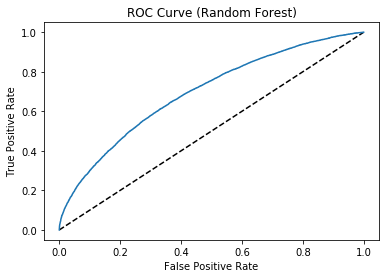

In [22]:
from sklearn.metrics import roc_curve

y_pred_prob = rf.predict_proba(X_test_pos)[:,1]
# we unpack the result into three variables: False Postiive Rate
# True Positive Rate, and Thresholds (the values of p)
fpr, tpr, thresholds = roc_curve(y_test_pos, y_pred_prob)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.show()

In [23]:
from sklearn.neural_network import MLPClassifier
# what about 2 variable classification? How does that work with MLP


mlp = MLPClassifier(hidden_layer_sizes=(20,), activation='logistic', alpha=0.0008883, learning_rate='invscaling', 
                   tol=0.000583)

mlp.fit(X_train_pos, y_train_pos)
mlp_y_new_pred = mlp.predict(X_test_pos)
print(mlp.score(X_test_pos, y_test_pos))
print(classification_report(y_test_pos, mlp_y_new_pred))

0.666966666667
             precision    recall  f1-score   support

          0       0.70      0.78      0.74     18170
          1       0.59      0.49      0.54     11830

avg / total       0.66      0.67      0.66     30000



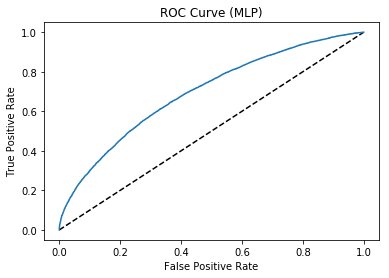

In [24]:
from sklearn.metrics import roc_curve

y_pred_prob_mlp = rf.predict_proba(X_test_pos)[:,1]
# we unpack the result into three variables: False Postiive Rate
# True Positive Rate, and Thresholds (the values of p)
fpr, tpr, thresholds = roc_curve(y_test_pos, y_pred_prob_mlp)

plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (MLP)')
plt.show()